In [16]:
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [98]:
def _get_images_df() -> pd.DataFrame:
    images_df: pd.DataFrame = pd.DataFrame()
    for dirname, _, filenames in os.walk('../input/A1'):
        _imgs: list = glob(f'{dirname}/*.tif')
        if len(_imgs):
            images_df = pd.concat([images_df, pd.DataFrame(_imgs)], axis=0)
    images_df.columns = ['rel_path']
    images_df['name'] = images_df['rel_path'].apply(lambda x: x.split('/')[-1])
    return images_df

### We can see the name completely encodes the information of the folder's distribution 

In [99]:
images_df = _get_images_df()
images_df

rel_path           name
0   ../input/A1/c1/r3/images/e7/c1r3e7n36.tif  c1r3e7n36.tif
1   ../input/A1/c1/r3/images/e7/c1r3e7n47.tif  c1r3e7n47.tif
2   ../input/A1/c1/r3/images/e7/c1r3e7n15.tif  c1r3e7n15.tif
3    ../input/A1/c1/r3/images/e7/c1r3e7n1.tif   c1r3e7n1.tif
4   ../input/A1/c1/r3/images/e7/c1r3e7n30.tif  c1r3e7n30.tif
..                                        ...            ...
45  ../input/A1/c3/r1/images/e3/c3r1e3n47.tif  c3r1e3n47.tif
46  ../input/A1/c3/r1/images/e3/c3r1e3n30.tif  c3r1e3n30.tif
47  ../input/A1/c3/r1/images/e3/c3r1e3n46.tif  c3r1e3n46.tif
48  ../input/A1/c3/r1/images/e3/c3r1e3n33.tif  c3r1e3n33.tif
49  ../input/A1/c3/r1/images/e3/c3r1e3n48.tif  c3r1e3n48.tif

[3206 rows x 2 columns]

### The following plots seem to suggest just 'c' and 'r' are significative: since the first 3 plots (first row) are the same pattern and, while they present different 'e' and 'n' values, 'c' and 'r' are the same

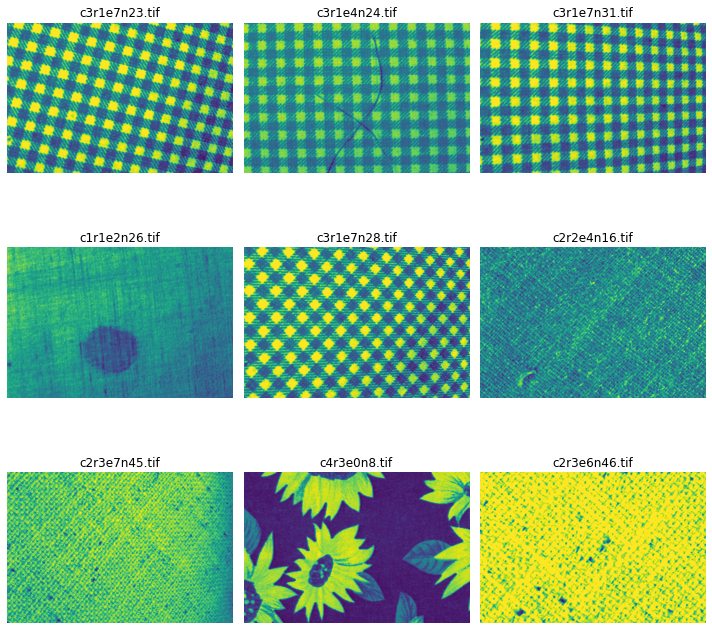

In [23]:
def _plot_samples(_idxs: list = None) -> None:
    _rows, _cols = 3, 3
    fig, axes = plt.subplots(3, 3, figsize = (10, 10))
    if _idxs is None:
        _idxs = list(np.random.randint(len(images_df), size=_rows * _cols))
    
    axes = axes.flatten()
    images = [Image.open(images_df.iloc[_i]['rel_path']) for _i in _idxs]
    labels_class = [images_df.iloc[_i]['name'] for _i in _idxs]


    for img, ax, lab in zip(images, axes, labels_class):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(lab)
    plt.tight_layout()
    plt.show()
    
_plot_samples()

### To confirm this hypothesis we will find all the possible combinations

In [79]:
from typing import Tuple

def _retrieve_c_r_combinations(_x) -> Tuple:
    _x['c'] = _x[:2]
    _x['r'] = _x[2:4]
    return _x

names_df = pd.DataFrame()
names_df['c'] = images_df['name'].apply(lambda x: x[:2] if str(x[:2]).startswith('c') else '')
names_df['r'] = images_df['name'].apply(lambda x: x[2:4] if str(x[2:4]).startswith('r') else '')
# there are some outliers of image starting with numbers
patterns = names_df.drop_duplicates().set_index(['c', 'r'])
patterns

Empty DataFrame
Columns: []
Index: [(c1, r3), (c1, r1), (, ), (c2, r3), (c2, r2), (c4, r3), (c4, r1), (c3, r3), (c3, r1)]

In [85]:
patterns_list = [c+r for c, r in patterns.index if c+r != '']
patterns_list

['c1r3', 'c1r1', 'c2r3', 'c2r2', 'c4r3', 'c4r1', 'c3r3', 'c3r1']

### Analysis of the patterns

In [87]:
pattern_idxs = {_p: np.argwhere(images_df.where(
    images_df['name'].str.startswith(_p), other=0)['name'].values != 0).flatten() 
                for _p in patterns_list}

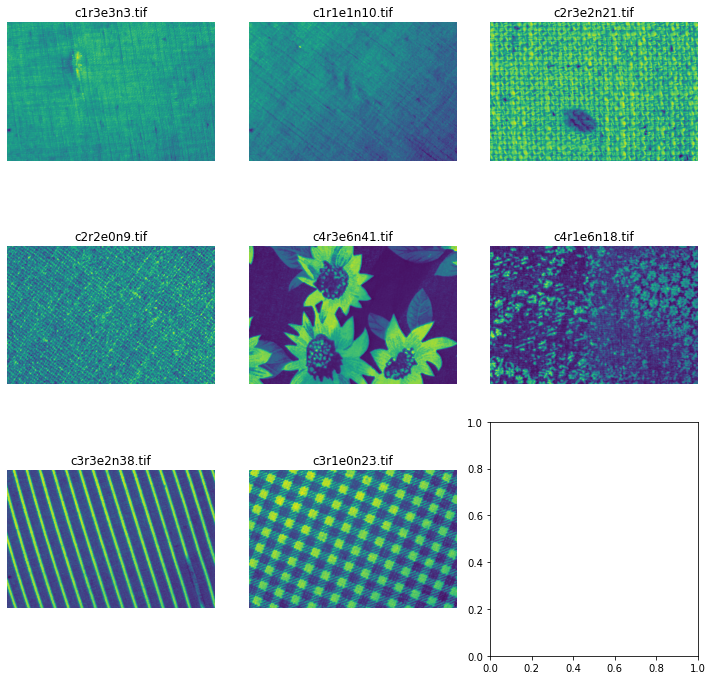

In [89]:
_idxs = [_p_idx[np.random.randint(len(_p_idx))] for _p_idx in list(pattern_idxs.values())]
_plot_samples(_idxs=_idxs)

#### The first pattern, 'c1r3', corresponds to: smooth textures (but with grooves & striations). We can check it with more samples of that pattern

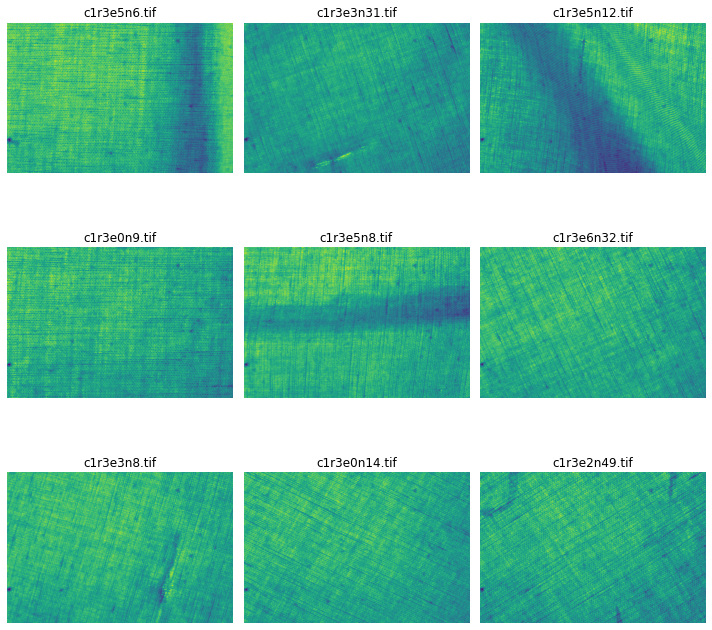

In [93]:
def _plot_pattern_samples(_pattern: str) -> None:
    _pattern_idx = np.argwhere(images_df.where(images_df['name'].str.startswith(_pattern), other=0)['name'].values != 0).flatten()
    _plot_samples(_idxs=_pattern_idx[np.random.randint(len(_pattern_idx), size=9)])
    
_plot_pattern_samples('c1r3')

### This is the only one very similar with another: the second one, 'c1r1'

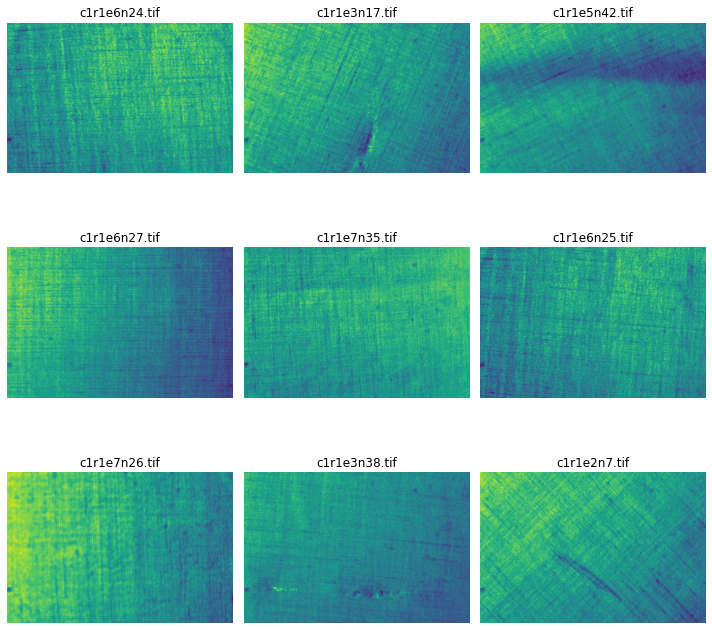

In [94]:
_plot_pattern_samples('c1r1')

# Conclusions

- 'c1r3' & 'c1r1': smooth textures with striation; denoted with class 1
- 'c2r3': crochet-like; ; denoted with class 2
- 'c2r2': denim; denoted with class 3
- 'c4r1': mosaic-like texture (small leaf-like shapes); denoted with class 4
- 'c4r3': tulips; denoted with class 5
- 'c3r3': wide parallel lines; denoted with class 6
- 'c3r1': squares; denoted with class 7

Also, as below is proved, the ones that do not fulfill these criteria are also mosaic-like (except 'pic10.tif' = 'guy in a desk' and 'test2.tif' = 'a rule'):
- 'pic10.tif': guy in a desk; class 8
- 'test2.tif': rule; class 9
- '< number >.tif': mosaic, class 4

In [112]:
_pattern_to_class = {'c1r3': 1, 'c1r1': 1, 'c2r3': 2, 'c2r2': 3, 'c4r3': 4, 'c4r1': 5, 'c3r3': 6, 'c3r1': 7}

In [113]:
outliers = images_df['name']

In [114]:
def _path_to_texture() -> pd.DataFrame:
    images_df = _get_images_df()
    images_df['texture'] = images_df['name'].apply(lambda x: _pattern_to_class.get(x[:4], 'unknown'))
    return images_df

_images_labeled = _path_to_texture()

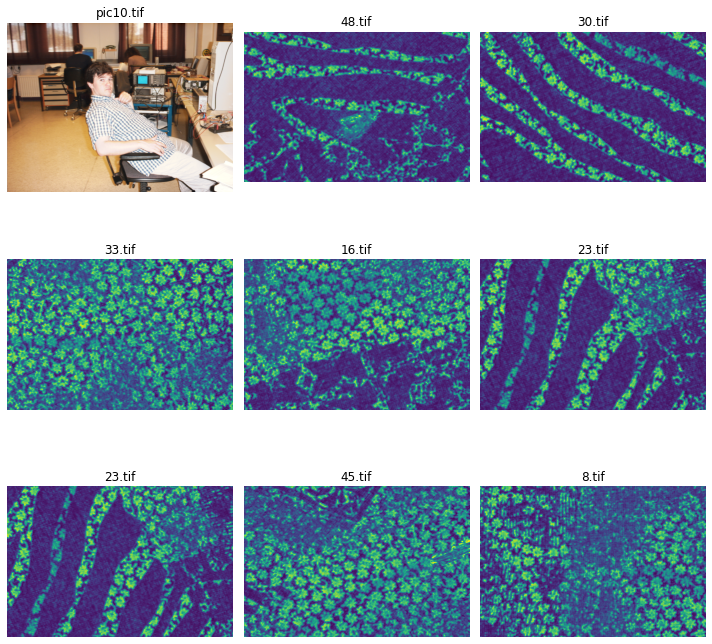

In [116]:
outliers_idx = np.argwhere(_images_labeled.where(_images_labeled['texture'] == 'unknown', other=0)['texture'].values != 0).flatten()
_plot_samples(_idxs=outliers_idx[np.random.randint(len(outliers_idx), size=9)])

In [126]:
_images_labeled.loc[_images_labeled['name'] == 'pic10.tif'] = _images_labeled.loc[_images_labeled['name'] == 'pic10.tif'].replace({'texture': 'unknown'}, {'texture': 8}) 
_images_labeled.loc[_images_labeled['name'] == 'test2.tif'] = _images_labeled.loc[_images_labeled['name'] == 'test2.tif'].replace({'texture': 'unknown'}, {'texture': 9}) 

In [128]:
_images_labeled = _images_labeled.replace({'texture': 'unknown'}, {'texture': 4})  # the rest are mosaic-like 

In [132]:
_images_labeled.to_csv('yellow-mission.csv', index=False)